### 第0️⃣步: 载入库

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 第1️⃣步: 载入数据
数据来源：Kaggle
https://www.kaggle.com/c/facial-keypoints-detection

In [2]:
df = pd.read_csv('data/training.csv')

In [3]:
# 数据分析

In [4]:
df.shape

(7049, 31)

In [6]:
df.columns

Index([u'left_eye_center_x', u'left_eye_center_y', u'right_eye_center_x',
       u'right_eye_center_y', u'left_eye_inner_corner_x',
       u'left_eye_inner_corner_y', u'left_eye_outer_corner_x',
       u'left_eye_outer_corner_y', u'right_eye_inner_corner_x',
       u'right_eye_inner_corner_y', u'right_eye_outer_corner_x',
       u'right_eye_outer_corner_y', u'left_eyebrow_inner_end_x',
       u'left_eyebrow_inner_end_y', u'left_eyebrow_outer_end_x',
       u'left_eyebrow_outer_end_y', u'right_eyebrow_inner_end_x',
       u'right_eyebrow_inner_end_y', u'right_eyebrow_outer_end_x',
       u'right_eyebrow_outer_end_y', u'nose_tip_x', u'nose_tip_y',
       u'mouth_left_corner_x', u'mouth_left_corner_y', u'mouth_right_corner_x',
       u'mouth_right_corner_y', u'mouth_center_top_lip_x',
       u'mouth_center_top_lip_y', u'mouth_center_bottom_lip_x',
       u'mouth_center_bottom_lip_y', u'Image'],
      dtype='object')

In [7]:
def string2image(string):
    """Converts a string to a numpy array."""
    return np.array([int(item) for item in string.split()]).reshape((96, 96))

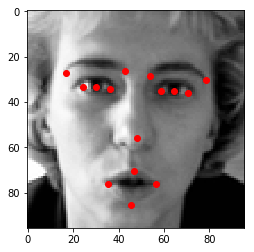

In [8]:
select = 1 #Index of images
keypoint_cols = list(df.columns)[:-1]
keypoints = df.loc[select][keypoint_cols]
xy = keypoints.values.reshape((15, 2))
plt.plot(xy[:, 0], xy[:, 1], 'ro')
plt.imshow(string2image(df.loc[select]['Image']), cmap='gray')

In [9]:
def plot_faces_with_keypoints(nrows=5, ncols=5):
    """Randomly displays some faces from the training data with their keypoints."""
    selection = np.random.choice(df.index, size=(nrows*ncols), replace=False)
    image_strings = df.loc[selection]['Image']
    keypoint_cols = list(df.columns)[:-1]
    keypoints = df.loc[selection][keypoint_cols]
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for string, (iloc, keypoint), ax in zip(image_strings, keypoints.iterrows(), axes.ravel()):
        xy = keypoint.values.reshape((15, 2))
        ax.imshow(string2image(string), cmap='gray')
        ax.plot(xy[:, 0], xy[:, 1], 'ro')
        ax.axis('off')

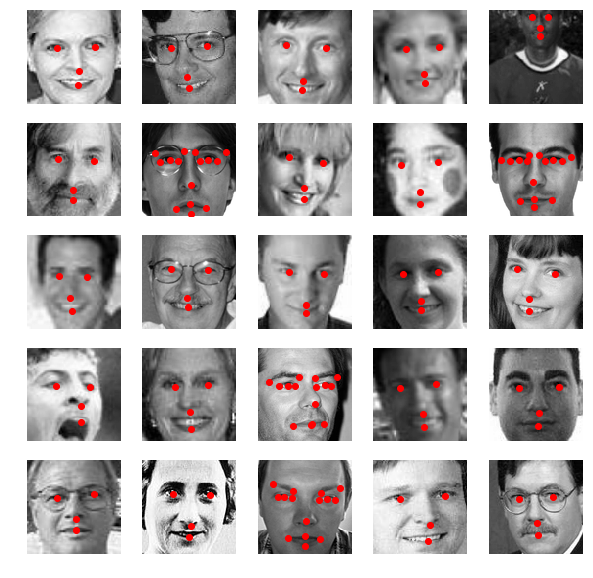

In [10]:
plot_faces_with_keypoints()

In [11]:
# 数据预处理

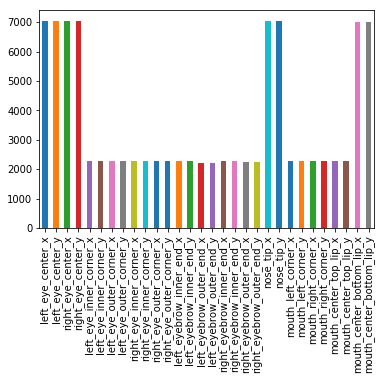

In [12]:
df.describe().loc['count'].plot.bar()

In [13]:
fully_annotated = df.dropna()

In [14]:
fully_annotated.shape

(2140, 31)

In [ ]:
# 获取X与y

In [15]:
X = np.stack([string2image(string) for string in fully_annotated['Image']]).astype(np.float)[:, :, :, np.newaxis]

In [16]:
y = np.vstack(fully_annotated[fully_annotated.columns[:-1]].values)

In [17]:
X.shape, X.dtype

((2140, 96, 96, 1), dtype('float64'))

In [18]:
y.shape, y.dtype

((2140, 30), dtype('float64'))

In [19]:
print X.max(), X.min(), y.max(), y.min()

255.0 0.0 95.80898312149999 3.82624305628


In [ ]:
# 数据归一化

In [20]:
X_train = X / 255.

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1))
)

y_train = output_pipe.fit_transform(y)

In [22]:
X_train.reshape(y_train.shape[0], -1).shape, y_train.shape

((2140, 9216), (2140, 30))

### 第2️⃣步：建立模型

In [23]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D

/Users/likaiwei/anaconda2/envs/ipykernel_py2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [24]:
model = Sequential()
model.add(Dense(100, activation="relu", input_shape=(96*96,)))
model.add(Activation('relu'))
model.add(Dense(30))

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               921700    
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________


### 第3️⃣步: 训练模型

In [26]:
from keras import optimizers

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 10
history = model.fit(X_train.reshape(y_train.shape[0], -1), y_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=20)

Train on 1712 samples, validate on 428 samples
Epoch 1/10
1712/1712 [==============================] - 1s 795us/step - loss: 0.0590 - acc: 0.2588 - val_loss: 0.0742 - val_acc: 0.0561
Epoch 2/10
1712/1712 [==============================] - 1s 699us/step - loss: 0.0370 - acc: 0.3715 - val_loss: 0.0692 - val_acc: 0.0584
Epoch 3/10
1712/1712 [==============================] - 1s 706us/step - loss: 0.0336 - acc: 0.3908 - val_loss: 0.0678 - val_acc: 0.0537
Epoch 4/10
1712/1712 [==============================] - 1s 695us/step - loss: 0.0322 - acc: 0.4200 - val_loss: 0.0670 - val_acc: 0.0444
Epoch 5/10
1712/1712 [==============================] - 1s 700us/step - loss: 0.0312 - acc: 0.4241 - val_loss: 0.0669 - val_acc: 0.0514
Epoch 6/10
1712/1712 [==============================] - 1s 716us/step - loss: 0.0303 - acc: 0.4322 - val_loss: 0.0661 - val_acc: 0.0444
Epoch 7/10
1712/1712 [==============================] - 1s 706us/step - loss: 0.0295 - acc: 0.4246 - val_loss: 0.0661 - val_acc: 0.0491
E

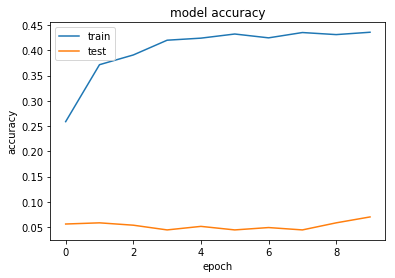

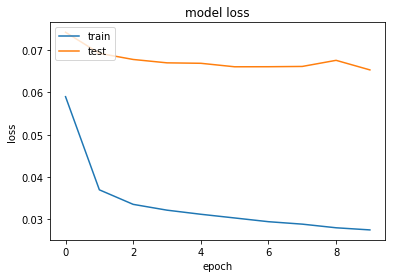

In [27]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 第4️⃣步: 模型预测

In [28]:
img = X_train[0, :, :, :].reshape(1, -1)
predictions = model.predict(img)

In [29]:
xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)

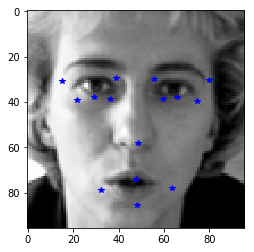

In [30]:
select = 1
plt.imshow(X_train[select, :, :, 0], cmap='gray')
plt.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'b*')

### 第5️⃣步: 结果评估

In [31]:
def plot_faces_with_keypoints_and_predictions(model, nrows=5, ncols=5, model_input='flat'):
    """Plots sampled faces with their truth and predictions."""
    selection = np.random.choice(np.arange(X.shape[0]), size=(nrows*ncols), replace=False)
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for ind, ax in zip(selection, axes.ravel()):
        img = X_train[ind, :, :, 0]
        if model_input == 'flat':
            predictions = model.predict(img.reshape(1, -1))
        else:
            predictions = model.predict(img[np.newaxis, :, :, np.newaxis])
        xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)
        ax.imshow(img, cmap='gray')
        ax.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'b*')
        ax.axis('off')

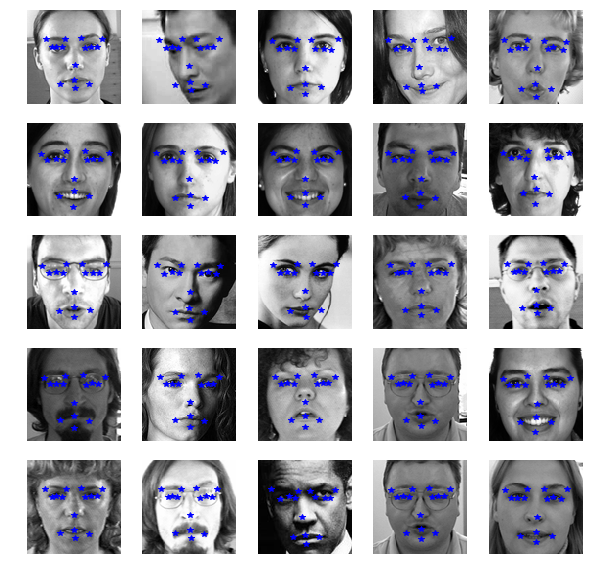

In [32]:
plot_faces_with_keypoints_and_predictions(model)

### 改进：采用卷积神经网络模型

In [33]:
from keras.layers import Dropout, Flatten

In [34]:
model = Sequential()
# input layer
model.add(BatchNormalization(input_shape=(96, 96, 1)))
model.add(Conv2D(24, (5, 5), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 2
model.add(Conv2D(36, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 3
model.add(Conv2D(48, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 4
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 5
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
# layer 6
model.add(Dense(500, activation="relu"))
# layer 7
model.add(Dense(90, activation="relu"))
# layer 8
model.add(Dense(30))

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 24)        624       
_________________________________________________________________
activation_2 (Activation)    (None, 92, 92, 24)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 24)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 46, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 36)        21636     
_________________________________________________________________
activation_3 (Activation)    (None, 42, 42, 36)        0         
__________

In [36]:
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 10
history = model.fit(X_train, y_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=20)

Train on 1712 samples, validate on 428 samples
Epoch 1/10
1712/1712 [==============================] - 45s 26ms/step - loss: 0.0383 - acc: 0.2845 - val_loss: 0.0684 - val_acc: 0.0327
Epoch 2/10
1712/1712 [==============================] - 45s 26ms/step - loss: 0.0351 - acc: 0.3277 - val_loss: 0.0693 - val_acc: 0.0327
Epoch 3/10
1712/1712 [==============================] - 44s 26ms/step - loss: 0.0330 - acc: 0.3335 - val_loss: 0.0658 - val_acc: 0.0374
Epoch 4/10
1712/1712 [==============================] - 45s 26ms/step - loss: 0.0269 - acc: 0.3984 - val_loss: 0.0548 - val_acc: 0.1121
Epoch 5/10
1712/1712 [==============================] - 45s 26ms/step - loss: 0.0218 - acc: 0.4317 - val_loss: 0.0521 - val_acc: 0.1285
Epoch 6/10
1712/1712 [==============================] - 44s 25ms/step - loss: 0.0190 - acc: 0.4609 - val_loss: 0.0460 - val_acc: 0.1379
Epoch 7/10
1712/1712 [==============================] - 44s 26ms/step - loss: 0.0173 - acc: 0.4562 - val_loss: 0.0434 - val_acc: 0.1262
E

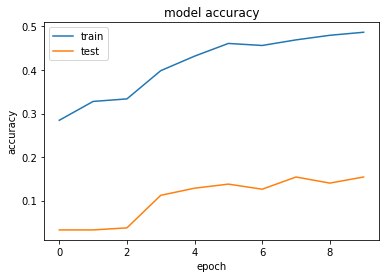

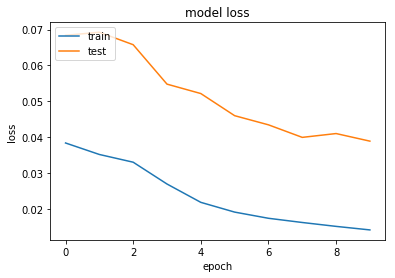

In [37]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

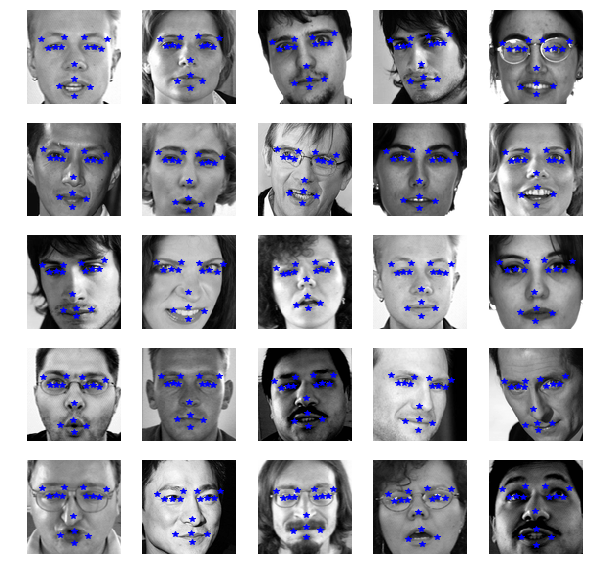

In [38]:
plot_faces_with_keypoints_and_predictions(model, model_input='2d')

In [ ]:
def plot_faces(nrows=5, ncols=5):
    """Randomly displays some faces from the training data."""
    selection = np.random.choice(df.index, size=(nrows*ncols), replace=False)
    image_strings = df.loc[selection]['Image']
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for string, ax in zip(image_strings, axes.ravel()):
        ax.imshow(string2image(string), cmap='gray')
        ax.axis('off')